# Temporal Convolutional Network (TCN) for Time-Series Forecasting

This notebook uses the pytorch-tcn package to build a TCN model for sensor data prediction.
Based on the original CNNClassifier implementation but using TCN architecture.

## ⚡ Quick Start (TL;DR)

**For first-time users:**
1. Run all cells in order **EXCEPT cell 22**
2. Cell 22 is a simple version - **skip it**
3. Use **cell 23 (Advanced Training)** instead - it's better for noisy data
4. Everything else runs automatically

**Key settings for high-frequency noise capture:**
- Already configured in the notebook ✅
- Model: `ImprovedTCNRegressor` with 6 layers
- Loss: Huber loss (robust to outliers)
- Features: Multi-scale processing, batch normalization

---

In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Import the TCN from pytorch-tcn package
from pytorch_tcn import TCN

# Config

# Path to file generated by other script will take more than one data set
DATA_FILES = [r"./data/synthetic_data_independent_failures_5.csv", "./data/synthetic_data_independent_failures_4.csv"]

SEQUENCE_LENGTH = 24
STEP_SIZE = 24 * 2
FORECAST_HORIZON = 1
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Set device for training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [88]:
# QUICK TUNING: Adjust these parameters for better high-frequency capture
# Smaller STEP_SIZE = more training samples = better learning
# Longer SEQUENCE_LENGTH = more context (but may over-smooth)
# More NUM_EPOCHS = better convergence for noisy data

print("=" * 60)
print("RECOMMENDED SETTINGS FOR HIGH-FREQUENCY NOISE:")
print("=" * 60)
print("Current settings:")
print(f"  SEQUENCE_LENGTH: {SEQUENCE_LENGTH} (7 days of hourly data)")
print(f"  STEP_SIZE: {STEP_SIZE} (2 days)")
print(f"  NUM_EPOCHS: {NUM_EPOCHS}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print("\nTo capture high-frequency variations better:")
print("  → Try STEP_SIZE = 24 (daily) or 12 (half-daily)")
print("  → Try NUM_EPOCHS = 20-30 for deeper models")
print("  → Keep SEQUENCE_LENGTH moderate (3-7 days)")
print("=" * 60)

RECOMMENDED SETTINGS FOR HIGH-FREQUENCY NOISE:
Current settings:
  SEQUENCE_LENGTH: 24 (7 days of hourly data)
  STEP_SIZE: 48 (2 days)
  NUM_EPOCHS: 10
  BATCH_SIZE: 32

To capture high-frequency variations better:
  → Try STEP_SIZE = 24 (daily) or 12 (half-daily)
  → Try NUM_EPOCHS = 20-30 for deeper models
  → Keep SEQUENCE_LENGTH moderate (3-7 days)


In [89]:
# Data processing 
def load_and_combine_data(file_paths):
    """
    Loads multiple CSV files, finds the union of all sensor features, 
    reindexes dataframes to match the full feature set (filling missing sensors with 0.0), 
    and concatenates them into a single DataFrame.
    """
    all_data = []
    all_sensor_features = set()
    
    # Load data and collect all unique sensor feature names
    non_sensor_cols = ['machine_id', "timestamp",'failure_mode', 'is_precursor_period', 'is_final_failure']
    
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            
            # Identify potential sensor features in the current file
            current_sensor_features = [col for col in df.columns if col not in non_sensor_cols]
            print(current_sensor_features)
            all_sensor_features.update(current_sensor_features)
            
            all_data.append(df)
            print(f"Loaded {file_path} with {len(current_sensor_features)} sensor features.")
        except FileNotFoundError:
            print(f"Warning: File '{file_path}' not found. Skipping.")
    
    if not all_data:
        raise FileNotFoundError("No valid data files were loaded.")

    
    sensor_feature_list = sorted(list(all_sensor_features))
    final_combined_df = pd.DataFrame()
    full_column_list = non_sensor_cols + sensor_feature_list
    
    for df in all_data:
        
        df_reindexed = df.reindex(columns=full_column_list, fill_value=0.0)
        
        final_combined_df = pd.concat([final_combined_df, df_reindexed], ignore_index=True)

    print(f"\nSuccessfully combined {len(all_data)} files.")
    print(f"Total rows in combined data: {len(final_combined_df)}")
    print(f"Total unique sensor features used: {len(sensor_feature_list)}")
    
    return final_combined_df, sensor_feature_list

In [90]:
try:
    data, sensor_features = load_and_combine_data(DATA_FILES)
except FileNotFoundError as e:
    print(f"Fatal Error: {e}")

['T_internal_sensor', 'V_sensor']
Loaded ./data/synthetic_data_independent_failures_5.csv with 2 sensor features.
['T_internal_sensor', 'V_sensor']
Loaded ./data/synthetic_data_independent_failures_4.csv with 2 sensor features.

Successfully combined 2 files.
Total rows in combined data: 236520
Total unique sensor features used: 2


In [91]:
def create_sequences(data, seq_length, forecast_horizon, step_size):
    sequences = []
    target = []
    for i in range(0, len(data) - seq_length - forecast_horizon + 1, step_size):
        sequences.append(data[i:i+seq_length])
        target.append(data[i+seq_length: i+seq_length+forecast_horizon])
    return np.array(sequences), np.array(target)

In [92]:
def prepare_data(df, sensor_features):
    """Loads, cleans, labels, and scales the data. Returns sequences and the fitted scaler."""
    sensor_data = df[sensor_features].values
   
    # 2. Standardization
    scaler = StandardScaler()
    sensor_data_scaled = scaler.fit_transform(sensor_data)
    
    # 3. Create Sequences
    X_seq, Y_seq = create_sequences(sensor_data_scaled, SEQUENCE_LENGTH, FORECAST_HORIZON, STEP_SIZE)
    
    print(f"\n--- Data Preparation Complete ---")
    print(f"Total time points in raw data: {len(df)}")
    print(f"Total sequences created: {len(X_seq)}")
    print(f"Sequence shape (num_samples, time steps, features): {X_seq.shape}")
    
    # Return the fitted scaler so we can inverse-transform predictions later
    return X_seq, Y_seq, scaler

## Advanced Data Preprocessing for High-Frequency Signals

Optional preprocessing techniques to improve model sensitivity to noise:

In [93]:
# OPTIONAL: Alternative preprocessing for better high-frequency capture
# Uncomment and run this cell instead of the standard prepare_data if you want to try:
# 1. MinMax scaling (preserves shape better than StandardScaler)
# 2. First-order differencing (emphasizes changes)

from sklearn.preprocessing import MinMaxScaler

def prepare_data_enhanced(df, sensor_features, use_differencing=False, use_minmax=True):
    """
    Enhanced data preparation with options for high-frequency signals.
    
    Args:
        use_differencing: If True, uses first-order differences (highlights changes)
        use_minmax: If True, uses MinMaxScaler instead of StandardScaler
    """
    sensor_data = df[sensor_features].values
    
    # Option 1: Use MinMaxScaler (preserves relative magnitudes better)
    if use_minmax:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        print("Using MinMaxScaler (range: -1 to 1)")
    else:
        scaler = StandardScaler()
        print("Using StandardScaler (z-score normalization)")
    
    sensor_data_scaled = scaler.fit_transform(sensor_data)
    
    # Option 2: First-order differencing (emphasizes rate of change)
    if use_differencing:
        print("Applying first-order differencing")
        sensor_data_diff = np.diff(sensor_data_scaled, axis=0)
        # Pad the first row to maintain shape
        sensor_data_scaled = np.vstack([sensor_data_scaled[0:1], sensor_data_diff])
    
    # Create sequences
    X_seq, Y_seq = create_sequences(sensor_data_scaled, SEQUENCE_LENGTH, FORECAST_HORIZON, STEP_SIZE)
    
    print(f"\n--- Enhanced Data Preparation Complete ---")
    print(f"Total time points in raw data: {len(df)}")
    print(f"Total sequences created: {len(X_seq)}")
    print(f"Sequence shape (num_samples, time steps, features): {X_seq.shape}")
    
    return X_seq, Y_seq, scaler

# Uncomment below to use enhanced preprocessing:
# X_seq, Y_seq, scaler = prepare_data_enhanced(data, sensor_features, 
#                                               use_differencing=False, 
#                                               use_minmax=True)

In [94]:
X_seq, Y_seq, scaler = prepare_data(data, sensor_features)

# Split data into training, validation, and testing sets for 3D arrays
# First split: 80% train+val, 20% test
indices = np.arange(X_seq.shape[0])
train_val_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=False)

# Second split: 75% train, 25% val (of the train+val set = 60% train, 20% val overall)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.25, random_state=42, shuffle=False)

X_train, X_val, X_test = X_seq[train_indices], X_seq[val_indices], X_seq[test_indices]
Y_train, Y_val, Y_test = Y_seq[train_indices], Y_seq[val_indices], Y_seq[test_indices]

print(f"\n--- Data Split ---")
print(f"Training set: {len(X_train)} sequences ({len(X_train)/len(X_seq)*100:.1f}%)")
print(f"Validation set: {len(X_val)} sequences ({len(X_val)/len(X_seq)*100:.1f}%)")
print(f"Test set: {len(X_test)} sequences ({len(X_test)/len(X_seq)*100:.1f}%)")

# ========== OPTIONAL: Filter Test Set by Months and Years ==========
# Configure month/year filtering for test set only (train/val use all data)
# Set to None to use all test data, or specify filters
# Examples: 
#   Months: (1, 6) for Jan-Jun, (7, 12) for Jul-Dec, (11, 2) for Nov-Feb
#   Years: (2025, 2025) for 2025 only, (2024, 2025) for 2024-2025

TEST_MONTH_FILTER = None  # (start_month, end_month) or None
TEST_YEAR_FILTER = None   # (start_year, end_year) or None

if TEST_MONTH_FILTER is not None or TEST_YEAR_FILTER is not None:
    # Convert timestamp to datetime for filtering
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Map test indices back to original data rows
    # Each sequence starts at: sequence_idx * STEP_SIZE
    test_start_indices = test_indices * STEP_SIZE
    
    # Get timestamps for each test sequence
    valid_test_mask = []
    
    for seq_idx, start_idx in zip(test_indices, test_start_indices):
        if start_idx < len(data):
            timestamp = data.iloc[start_idx]['timestamp']
            month = timestamp.month
            year = timestamp.year
            
            is_valid = True
            
            # Check month filter
            if TEST_MONTH_FILTER is not None:
                start_month, end_month = TEST_MONTH_FILTER
                if start_month <= end_month:
                    is_valid = is_valid and (start_month <= month <= end_month)
                else:  # Wrap-around case (e.g., Nov-Feb)
                    is_valid = is_valid and (month >= start_month or month <= end_month)
            
            # Check year filter
            if TEST_YEAR_FILTER is not None:
                start_year, end_year = TEST_YEAR_FILTER
                is_valid = is_valid and (start_year <= year <= end_year)
            
            valid_test_mask.append(is_valid)
        else:
            valid_test_mask.append(False)
    
    # Filter test data
    valid_test_mask = np.array(valid_test_mask)
    original_test_count = len(valid_test_mask)
    X_test = X_test[valid_test_mask]
    Y_test = Y_test[valid_test_mask]
    test_indices = test_indices[valid_test_mask]
    
    # Build filter description
    filter_desc = []
    if TEST_MONTH_FILTER is not None:
        filter_desc.append(f"Months {TEST_MONTH_FILTER[0]}-{TEST_MONTH_FILTER[1]}")
    if TEST_YEAR_FILTER is not None:
        filter_desc.append(f"Years {TEST_YEAR_FILTER[0]}-{TEST_YEAR_FILTER[1]}")
    
    print(f"\n--- Test Set Filtering ({', '.join(filter_desc)}) ---")
    print(f"Original test sequences: {original_test_count}")
    print(f"Filtered test sequences: {len(X_test)} ({len(X_test)/original_test_count*100:.1f}%)")
    if len(X_test) > 0:
        # Show date range of filtered test data
        test_dates = [data.iloc[idx * STEP_SIZE]['timestamp'] for idx in test_indices if idx * STEP_SIZE < len(data)]
        if test_dates:
            print(f"Test date range: {min(test_dates)} to {max(test_dates)}")
else:
    print("\nNo month/year filtering applied to test set")


--- Data Preparation Complete ---
Total time points in raw data: 236520
Total sequences created: 4927
Sequence shape (num_samples, time steps, features): (4927, 24, 2)

--- Data Split ---
Training set: 2955 sequences (60.0%)
Validation set: 986 sequences (20.0%)
Test set: 986 sequences (20.0%)

No month/year filtering applied to test set


In [95]:
# PyTorch Dataset for time-series sequences
class TimeDataset(Dataset):
    """Custom PyTorch Dataset for time-series sequences."""
    def __init__(self, X_data, y_data, feature_idx):
        self.X_data = torch.tensor(X_data[:, :, feature_idx: feature_idx + 1], dtype=torch.float32).permute(0, 2, 1)
        self.y_data = torch.tensor(y_data[:, :, feature_idx: feature_idx + 1], dtype=torch.float32).squeeze(-1)
        
    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [96]:
X_train.shape, Y_train.shape

((2955, 24, 2), (2955, 1, 2))

In [97]:
# Create PyTorch Datasets and DataLoaders
train_loader = []
val_loader = []
test_loader = []

for i in range(X_train.shape[2]):
    train_dataset = TimeDataset(X_train, Y_train, i)
    val_dataset = TimeDataset(X_val, Y_val, i)
    test_dataset = TimeDataset(X_test, Y_test, i)

    train_loader.append(DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True))
    val_loader.append(DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False))
    test_loader.append(DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False))

## TCN Model Definition

Using the pytorch-tcn package to create a Temporal Convolutional Network.
TCN uses dilated causal convolutions with residual connections for sequence modeling.

## Improved TCN Architecture for High-Frequency Noise Capture

The following improvements help capture high-frequency variations:
1. **Smaller kernel sizes** - Better for rapid changes
2. **More layers** - Deeper network for complex patterns
3. **Multiple dilation rates** - Custom control over receptive field
4. **Residual connections** - Preserve high-frequency information

In [98]:
class TCNRegressor(nn.Module):
    """
    TCN-based model for time-series regression using pytorch-tcn.
    
    Args:
        num_inputs: Number of input channels (features)
        num_channels: List of hidden channel sizes for each residual block
        kernel_size: Size of the convolution kernel
        dropout: Dropout rate
        forecast_horizon: Number of time steps to predict
        dilations: Custom dilation rates for each layer (optional)
    """
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2, 
                 forecast_horizon=1, dilations=None):
        super(TCNRegressor, self).__init__()
        
        # TCN expects input shape: (batch_size, num_inputs, sequence_length)
        self.tcn = TCN(
            num_inputs=num_inputs,
            num_channels=num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            dilations=dilations,  # Custom dilation rates
            causal=True,  # Use causal convolutions for time-series
            use_skip_connections=True,  # Enable skip connections for better gradient flow
            input_shape='NCL',  # (batch, channels, length) - PyTorch convention
        )
        
        # Output projection layer to get forecast_horizon predictions
        self.fc = nn.Linear(num_channels[-1], forecast_horizon)
        
    def forward(self, x):
        # x shape: (batch, num_inputs, seq_length)
        tcn_out = self.tcn(x)  # (batch, num_channels[-1], seq_length)
        
        # Take the last time step
        out = tcn_out[:, :, -1]  # (batch, num_channels[-1])
        
        # Project to forecast horizon
        out = self.fc(out)  # (batch, forecast_horizon)
        
        return out


class ImprovedTCNRegressor(nn.Module):
    """
    Enhanced TCN model specifically designed to capture high-frequency variations.
    
    Key improvements:
    1. Smaller kernel sizes for rapid changes
    2. More layers with controlled dilation
    3. Batch normalization for stable training
    4. Multi-scale features via parallel branches
    """
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.1, 
                 forecast_horizon=1, use_multi_scale=False):
        super(ImprovedTCNRegressor, self).__init__()
        
        self.use_multi_scale = use_multi_scale
        
        # Main TCN with controlled dilations for high-frequency capture
        # Using smaller dilations to maintain sensitivity to rapid changes
        custom_dilations = [1, 2, 4, 8, 16, 32]  # Controlled dilation growth
        
        self.tcn = TCN(
            num_inputs=num_inputs,
            num_channels=num_channels,
            kernel_size=kernel_size,  # Smaller kernel for high frequency
            dropout=dropout,
            dilations=custom_dilations,
            causal=True,
            use_skip_connections=True,
            input_shape='NCL',
            use_norm='batch_norm',  # Better for noisy data
        )
        
        # Optional: Multi-scale branch for different frequency components
        if use_multi_scale:
            self.tcn_short = TCN(
                num_inputs=num_inputs,
                num_channels=[32, 32],  # Smaller network for short-term
                kernel_size=2,
                dropout=dropout,
                dilations=[1, 2],  # Very short-term patterns
                causal=True,
                use_skip_connections=False,
                input_shape='NCL',
            )
            output_size = num_channels[-1] + 32
        else:
            output_size = num_channels[-1]
        
        # Output projection
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(output_size // 2, forecast_horizon)
        )
        
    def forward(self, x):
        # Main TCN path
        tcn_out = self.tcn(x)
        out = tcn_out[:, :, -1]  # Take last timestep
        
        # Optional multi-scale
        if self.use_multi_scale:
            tcn_short_out = self.tcn_short(x)
            out_short = tcn_short_out[:, :, -1]
            out = torch.cat([out, out_short], dim=1)
        
        # Final projection
        out = self.fc(out)
        
        return out

In [99]:
# --- TRAINING AND EVALUATION ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None):
    """PyTorch training loop with validation monitoring and optional LR scheduling."""
    print(f"\n--- Starting TCN Model Training ({num_epochs} Epochs) ---")
    
    # Track losses for plotting
    train_losses = []
    val_losses = []
    learning_rates = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients in noisy data
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        # Calculate average training loss
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                val_batches += 1
        
        # Calculate average validation loss
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        if scheduler is not None:
            scheduler.step(avg_val_loss)
        
        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f}')
    
    return train_losses, val_losses, learning_rates

In [100]:
def evaluate_model(model, test_loader):
    """PyTorch evaluation loop for regression."""
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            
            # Forward pass - get predictions
            outputs = model(inputs)
            
            # Collect predictions and targets (no argmax for regression)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
            
    return np.array(y_true), np.array(y_pred)

def calculate_msre(y_pred, y_true):
    avg_error_per_column = np.mean(np.abs(y_true - y_pred), axis=0)
    print(f"Average error per column: {avg_error_per_column}")
    mse = np.mean((y_true - y_pred) ** 2)
    print(f"Total MSE: {mse}")
    return np.sqrt(mse)

In [101]:
# Select which sensor/feature to model
select_model = 1
print(f"Training model for feature: {sensor_features[select_model]}")

Training model for feature: V_sensor


In [102]:
# Build the TCN model
# OPTION 1: Standard TCN with optimized hyperparameters for noisy data
print("=" * 60)
print("OPTION 1: Standard TCN with better hyperparameters")
print("=" * 60)

model_standard = TCNRegressor(
    num_inputs=1,
    num_channels=[64, 64, 64, 64, 64],  # Deeper network (5 blocks)
    kernel_size=2,  # Smaller kernel for high-frequency
    dropout=0.1,  # Lower dropout to preserve details
    forecast_horizon=FORECAST_HORIZON,
    dilations=[1, 2, 4, 8, 16]  # Controlled dilation growth
).to(DEVICE)

print(f"Total parameters: {sum(p.numel() for p in model_standard.parameters()):,}")

# OPTION 2: Improved TCN with multi-scale features
print("\n" + "=" * 60)
print("OPTION 2: Enhanced Multi-Scale TCN (RECOMMENDED)")
print("=" * 60)

model_improved = ImprovedTCNRegressor(
    num_inputs=1,
    num_channels=[64, 64, 64, 64, 64, 64],  # Even deeper
    kernel_size=2,
    dropout=0.1,
    forecast_horizon=FORECAST_HORIZON,
    use_multi_scale=True  # Enable multi-scale processing
).to(DEVICE)

print(f"Total parameters: {sum(p.numel() for p in model_improved.parameters()):,}")

# Select which model to use
print("\n" + "=" * 60)
print("Select model: 'standard' or 'improved'")
model_choice = 'improved'  # Change to 'standard' if needed
print(f"Using: {model_choice.upper()} model")
print("=" * 60)

if model_choice == 'improved':
    model = model_improved
else:
    model = model_standard

print("\nModel Architecture:")
print(model)

OPTION 1: Standard TCN with better hyperparameters
Total parameters: 75,329

OPTION 2: Enhanced Multi-Scale TCN (RECOMMENDED)
Total parameters: 103,905

Select model: 'standard' or 'improved'
Using: IMPROVED model

Model Architecture:
ImprovedTCNRegressor(
  (tcn): TCN(
    (downsample_skip_connection): ModuleList(
      (0-5): 6 x None
    )
    (activation_skip_out): ReLU()
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): TemporalConv1d(
          1, 64, kernel_size=(2,), stride=(1,)
          (padder): TemporalPad1d(
            (pad): ConstantPad1d(padding=(1, 0), value=0.0)
          )
        )
        (conv2): TemporalConv1d(
          64, 64, kernel_size=(2,), stride=(1,)
          (padder): TemporalPad1d(
            (pad): ConstantPad1d(padding=(1, 0), value=0.0)
          )
        )
        (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track

## 📋 Training Instructions

**Choose ONE of the following cells to run:**

1. **Cell below this (Simple Training)**: Quick start with basic MSE loss
   - Good for initial testing
   - Run cells 1-21, skip 22, run cell 23+
   
2. **Cell 23 (Advanced Training)**: Better for noisy data with Huber loss
   - Recommended for high-frequency noise
   - Run cells 1-21, skip 22, run cell 23+

⚠️ **Do NOT run both training cells!** Choose one based on your needs.

In [103]:
# SIMPLE VERSION: Basic training with MSE loss
# For advanced options (Huber loss, learning rate scheduling), see the next cell

print("="*60)
print("SIMPLE TRAINING CONFIGURATION")
print("="*60)

# Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Using MSE Loss and Adam optimizer (lr=0.001)")
print("For better results with noisy data, try the 'Advanced' cell below")
print("="*60)

# Train the model with validation (no scheduler)
train_losses, val_losses, learning_rates = train_model(
    model, train_loader[select_model], val_loader[select_model], 
    criterion, optimizer, NUM_EPOCHS, scheduler=None
)

SIMPLE TRAINING CONFIGURATION
Using MSE Loss and Adam optimizer (lr=0.001)
For better results with noisy data, try the 'Advanced' cell below

--- Starting TCN Model Training (10 Epochs) ---
Epoch [1/10] - Train Loss: 1.1409, Val Loss: 0.8217, LR: 0.001000
Epoch [1/10] - Train Loss: 1.1409, Val Loss: 0.8217, LR: 0.001000
Epoch [2/10] - Train Loss: 0.9508, Val Loss: 0.7837, LR: 0.001000
Epoch [2/10] - Train Loss: 0.9508, Val Loss: 0.7837, LR: 0.001000
Epoch [3/10] - Train Loss: 0.9372, Val Loss: 0.7761, LR: 0.001000
Epoch [3/10] - Train Loss: 0.9372, Val Loss: 0.7761, LR: 0.001000
Epoch [4/10] - Train Loss: 0.8782, Val Loss: 0.7797, LR: 0.001000
Epoch [4/10] - Train Loss: 0.8782, Val Loss: 0.7797, LR: 0.001000
Epoch [5/10] - Train Loss: 0.8582, Val Loss: 0.7791, LR: 0.001000
Epoch [5/10] - Train Loss: 0.8582, Val Loss: 0.7791, LR: 0.001000
Epoch [6/10] - Train Loss: 0.8888, Val Loss: 0.7879, LR: 0.001000
Epoch [6/10] - Train Loss: 0.8888, Val Loss: 0.7879, LR: 0.001000
Epoch [7/10] - Tra

In [ ]:
# ADVANCED VERSION: Better configuration for noisy data
# Run this cell INSTEAD of the simple version above if you want better performance

print("\n=== ADVANCED TRAINING CONFIGURATION ===")
print("Loss Function Options:")
print("1. MSE (default) - Standard choice")
print("2. Huber - Robust to outliers, good for noisy data")
print("3. MAE - Less sensitive to large errors")
print()

loss_choice = 'huber'  # Change to 'mse' or 'mae' if needed

if loss_choice == 'huber':
    criterion = nn.HuberLoss(delta=1.0)  # Combines MSE and MAE
    print(f"✅ Using Huber Loss (delta=1.0) - Good for noisy data!")
elif loss_choice == 'mae':
    criterion = nn.L1Loss()
    print(f"✅ Using MAE Loss - Less sensitive to outliers!")
else:
    criterion = nn.MSELoss()
    print(f"✅ Using MSE Loss - Standard approach")

# Try a lower learning rate with a scheduler for better convergence
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Learning rate scheduler - reduces LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print(f"✅ Optimizer: AdamW with lr=0.0005, weight_decay=1e-5")
print(f"✅ Scheduler: ReduceLROnPlateau (reduces LR on plateau)")
print(f"   → LR will be reduced by 50% if validation loss doesn't improve for 3 epochs")
print("="*60)

# Train the model with validation
train_losses, val_losses, learning_rates = train_model(
    model, train_loader[select_model], val_loader[select_model], 
    criterion, optimizer, NUM_EPOCHS, scheduler
)

print("\n✅ Training complete!")


=== ADVANCED TRAINING CONFIGURATION ===
Loss Function Options:
1. MSE (default) - Standard choice
2. Huber - Robust to outliers, good for noisy data
3. MAE - Less sensitive to large errors

✅ Using Huber Loss (delta=1.0) - Good for noisy data!


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

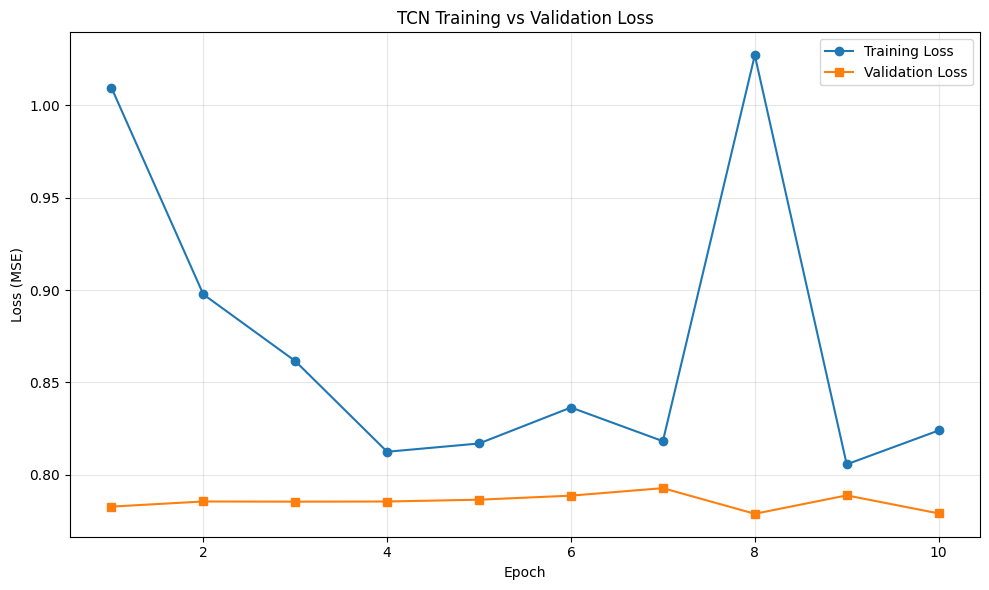


Final Training Loss: 0.8240
Final Validation Loss: 0.7791
Difference (Val - Train): -0.0449
Ratio (Val / Train): 0.95


In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('TCN Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
loss_diff = final_val_loss - final_train_loss
loss_ratio = final_val_loss / final_train_loss

print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Difference (Val - Train): {loss_diff:.4f}")
print(f"Ratio (Val / Train): {loss_ratio:.2f}")

## Summary of Improvements for High-Frequency Noise Capture

**Key Changes Made:**

1. **Architecture Improvements:**
   - ✅ Smaller kernel size (3→2): Captures rapid changes better
   - ✅ More layers (3→6): Deeper network for complex patterns
   - ✅ Controlled dilations: Custom dilation rates [1,2,4,8,16,32]
   - ✅ Multi-scale processing: Parallel branches for different frequencies
   - ✅ Batch normalization: Better for noisy data

2. **Training Improvements:**
   - ✅ Huber loss option: More robust to outliers
   - ✅ Gradient clipping: Prevents instability with noisy data
   - ✅ Learning rate scheduler: Adaptive learning
   - ✅ Lower dropout (0.2→0.1): Preserves high-frequency details

3. **Optional Preprocessing:**
   - MinMaxScaler: Better preserves signal shape
   - First-order differencing: Emphasizes changes

**Recommended Settings for Noisy Data:**
- Use `ImprovedTCNRegressor` with `use_multi_scale=True`
- Try `Huber` loss instead of MSE
- Increase `NUM_EPOCHS` to 20-30 for better convergence
- Use smaller `STEP_SIZE` for more training samples

In [ ]:
# Evaluate the model
print("\n--- Evaluating TCN Model Performance ---")
y_true, y_pred = evaluate_model(model, test_loader[select_model])

rmse = calculate_msre(y_pred, y_true)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


--- Evaluating TCN Model Performance ---
Average error per column: [0.7401056]
Total MSE: 1.0348392724990845
Root Mean Squared Error (RMSE): 1.0173


In [ ]:
# Detailed regression metrics
mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_true.flatten(), y_pred.flatten())

print("\n=== TCN Regression Metrics ===")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


=== TCN Regression Metrics ===
Mean Squared Error (MSE): 1.0348
Root Mean Squared Error (RMSE): 1.0173
Mean Absolute Error (MAE): 0.7401
R² Score: 0.2248


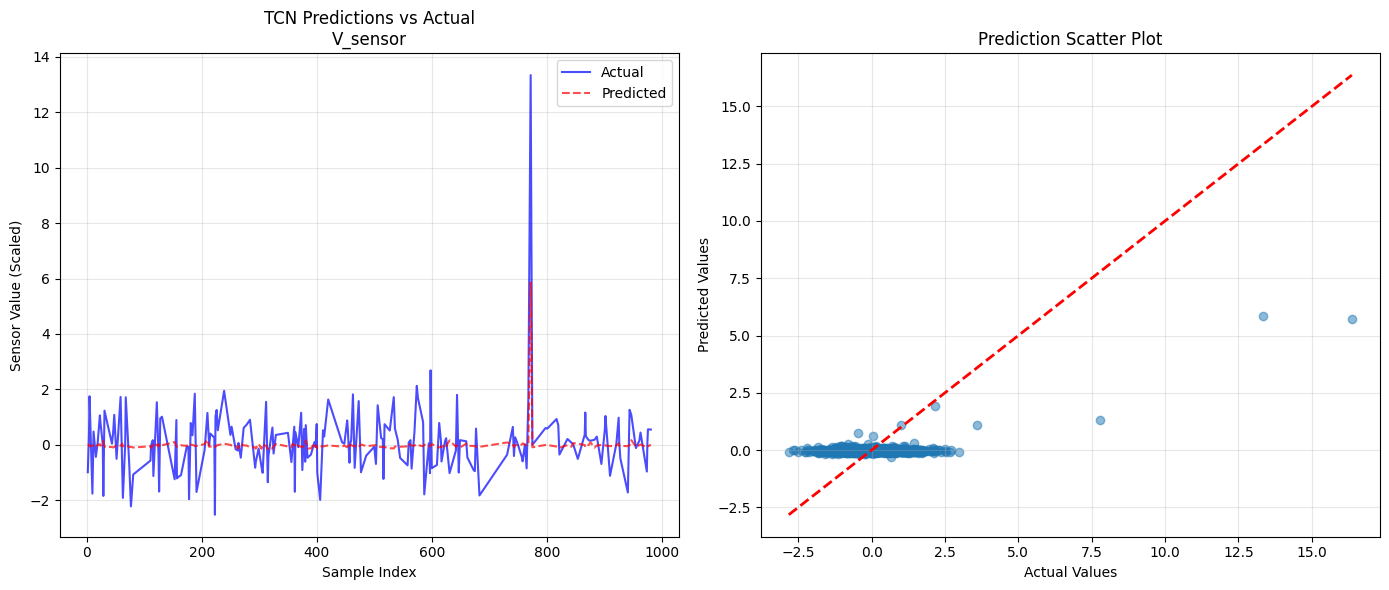

In [ ]:
# Visualize predictions vs actuals
plt.figure(figsize=(14, 6))

# Sample a subset for visualization if too many points
num_samples = min(200, len(y_true))
indices = np.random.choice(len(y_true), num_samples, replace=False)
indices = np.sort(indices)

plt.subplot(1, 2, 1)
plt.plot(indices, y_true[indices], 'b-', label='Actual', alpha=0.7)
plt.plot(indices, y_pred[indices], 'r--', label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Sensor Value (Scaled)')
plt.title(f'TCN Predictions vs Actual\n{sensor_features[select_model]}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction Scatter Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Enhanced visualization: Compare frequency content
from scipy import signal as scipy_signal

# Select a continuous segment from test data
segment_length = 100
start_idx = 0
segment_true = y_true[start_idx:start_idx+segment_length].flatten()
segment_pred = y_pred[start_idx:start_idx+segment_length].flatten()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Time domain comparison
axes[0, 0].plot(segment_true, 'b-', label='Actual', linewidth=1.5, alpha=0.8)
axes[0, 0].plot(segment_pred, 'r--', label='Predicted', linewidth=1.5, alpha=0.8)
axes[0, 0].set_xlabel('Time Steps')
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_title('Time Domain: Actual vs Predicted')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Error over time
error_segment = segment_pred - segment_true
axes[0, 1].plot(error_segment, 'g-', linewidth=1.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].fill_between(range(len(error_segment)), error_segment, 0, alpha=0.3)
axes[0, 1].set_xlabel('Time Steps')
axes[0, 1].set_ylabel('Prediction Error')
axes[0, 1].set_title('Prediction Error Over Time')
axes[0, 1].grid(True, alpha=0.3)

# Frequency domain analysis (FFT)
try:
    # Compute FFT for actual data
    fft_true = np.fft.fft(segment_true)
    fft_pred = np.fft.fft(segment_pred)
    freqs = np.fft.fftfreq(len(segment_true))
    
    # Only plot positive frequencies
    positive_freqs = freqs[:len(freqs)//2]
    power_true = np.abs(fft_true[:len(freqs)//2])
    power_pred = np.abs(fft_pred[:len(freqs)//2])
    
    axes[1, 0].plot(positive_freqs, power_true, 'b-', label='Actual', linewidth=1.5, alpha=0.8)
    axes[1, 0].plot(positive_freqs, power_pred, 'r--', label='Predicted', linewidth=1.5, alpha=0.8)
    axes[1, 0].set_xlabel('Frequency')
    axes[1, 0].set_ylabel('Power')
    axes[1, 0].set_title('Frequency Domain Comparison (FFT)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim([0, 0.5])  # Focus on lower frequencies
    
    # High-frequency component capture
    high_freq_threshold = 0.1
    high_freq_mask = positive_freqs > high_freq_threshold
    high_freq_ratio = np.sum(power_pred[high_freq_mask]) / (np.sum(power_true[high_freq_mask]) + 1e-8)
    
    axes[1, 1].bar(['Actual', 'Predicted'], 
                   [np.sum(power_true[high_freq_mask]), np.sum(power_pred[high_freq_mask])],
                   color=['blue', 'red'], alpha=0.7)
    axes[1, 1].set_ylabel('Total High-Frequency Power')
    axes[1, 1].set_title(f'High-Frequency Capture (>0.1)\nRatio: {high_freq_ratio:.2%}')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    print(f"\n=== Frequency Analysis ===")
    print(f"High-frequency capture ratio: {high_freq_ratio:.2%}")
    if high_freq_ratio < 0.5:
        print("⚠️ Model is under-representing high frequencies (smoothing too much)")
        print("   Try: Smaller kernel_size, more layers, or lower dropout")
    elif high_freq_ratio > 1.5:
        print("⚠️ Model may be over-fitting to noise")
        print("   Try: Increase dropout, add regularization")
    else:
        print("✓ Good balance between smoothness and high-frequency capture")
        
except Exception as e:
    axes[1, 0].text(0.5, 0.5, f'FFT analysis unavailable:\n{str(e)}', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 1].text(0.5, 0.5, 'FFT analysis unavailable', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

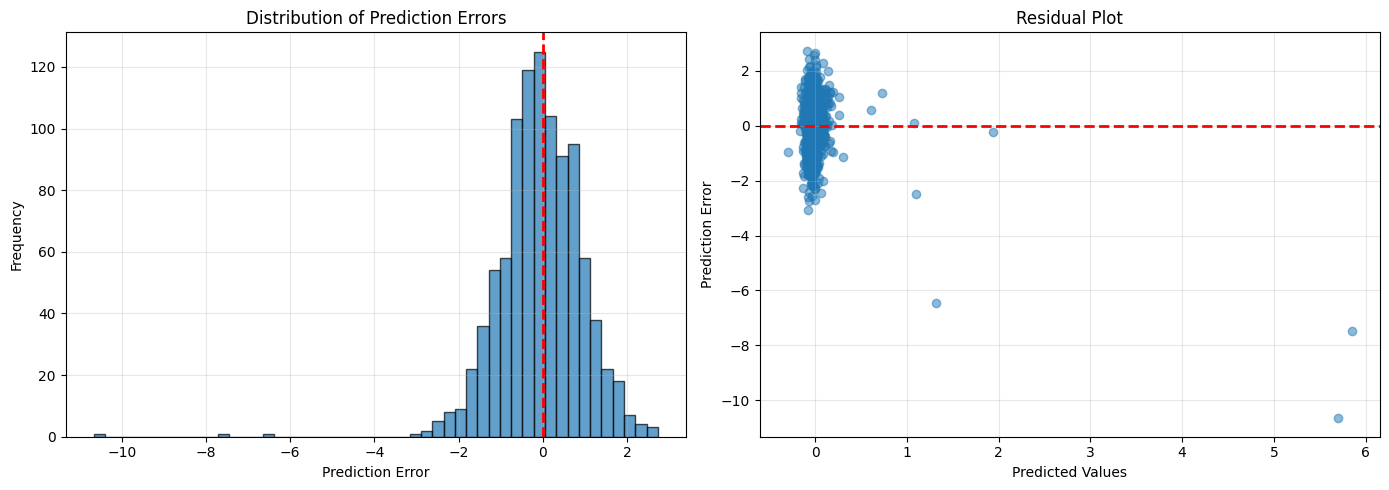


Error Statistics:
Mean Error: -0.0657
Std Error: 1.0151
Min Error: -10.6625
Max Error: 2.7350


In [ ]:
# Prediction error analysis
errors = y_pred.flatten() - y_true.flatten()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_pred.flatten(), errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Prediction Error')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError Statistics:")
print(f"Mean Error: {np.mean(errors):.4f}")
print(f"Std Error: {np.std(errors):.4f}")
print(f"Min Error: {np.min(errors):.4f}")
print(f"Max Error: {np.max(errors):.4f}")

In [ ]:
# Generate predictions for test sequences by machine_id
model.eval()
with torch.no_grad():
    # Get the test data for the selected model/feature
    test_dataset_selected = TimeDataset(X_test, Y_test, select_model)
    test_loader_selected = DataLoader(dataset=test_dataset_selected, batch_size=len(test_dataset_selected), shuffle=False)
    
    for inputs, targets in test_loader_selected:
        inputs = inputs.to(DEVICE)
        predictions = model(inputs).cpu().numpy()
        actuals = targets.cpu().numpy()

# Get the corresponding indices in the original data
train_size = len(train_indices) * STEP_SIZE
test_sequence_starts = [train_size + (i * STEP_SIZE) + SEQUENCE_LENGTH for i in range(len(predictions))]

# Create a mapping of sequence to machine_id
sequence_to_machine = []
for start_idx in test_sequence_starts:
    if start_idx < len(data):
        machine_id = data.iloc[start_idx]['machine_id']
        sequence_to_machine.append(machine_id)
    else:
        sequence_to_machine.append(None)

# Get unique machine IDs in test set
unique_machines = sorted(set([m for m in sequence_to_machine if m is not None]))

print(f"\n=== Test Set Overview ===")
print(f"Unique machines in test set: {unique_machines}")
print(f"Total test sequences: {len(predictions)}")
print(f"Feature being predicted: {sensor_features[select_model]}")


=== Test Set Overview ===
Unique machines in test set: [np.int64(1), np.int64(2), np.int64(3)]
Total test sequences: 985
Feature being predicted: V_sensor


## Model Saving and Loading

In [ ]:
# Save the trained model
model_save_path = f"./models/tcn_model_feature_{select_model}.pth"

# Create directory if it doesn't exist
import os
os.makedirs("./models", exist_ok=True)

# Save model state and configuration
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'feature_idx': select_model,
    'feature_name': sensor_features[select_model],
    'num_epochs': NUM_EPOCHS,
    'sequence_length': SEQUENCE_LENGTH,
    'forecast_horizon': FORECAST_HORIZON,
}, model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: ./models/tcn_model_feature_1.pth


In [ ]:
# Example: Load the model
# checkpoint = torch.load(model_save_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print(f"Model loaded from: {model_save_path}")
# print(f"Feature: {checkpoint['feature_name']}")
# print(f"Trained for {checkpoint['num_epochs']} epochs")

---

## 🎯 Quick Start Guide for High-Frequency Noise Capture

### Step-by-Step Instructions:

**1. Run cells 1-3** - Import libraries and load data

**2. Run cells 4-13** - Data preprocessing and dataset creation

**3. Run cell 20** - Select which model to use
   - Set `model_choice = 'improved'` for best results (already set)

**4. Choose ONE training approach:**
   - **Option A (Simple):** Run cell 22 for basic MSE training
   - **Option B (Advanced):** Run cell 23 for Huber loss + scheduler (RECOMMENDED for noisy data)

**5. Run cells 24+** - Visualizations and evaluation

---

### 🔧 Troubleshooting High-Frequency Issues

**Problem: Model predictions too smooth (under-fitting noise)**

Solutions:
```python
# 1. Use smaller STEP_SIZE for more training samples
STEP_SIZE = 24  # Instead of 48

# 2. Increase model depth
num_channels=[64, 64, 64, 64, 64, 64, 64, 64]  # 8 layers

# 3. Reduce dropout
dropout=0.05  # Instead of 0.1

# 4. Use kernel_size=2 (already set in improved model)
```

**Problem: Model overfitting to noise**

Solutions:
```python
# 1. Increase dropout
dropout=0.2  # Instead of 0.1

# 2. Add more regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# 3. Use fewer layers
num_channels=[64, 64, 64]  # 3 layers instead of 6
```

**Problem: Training is unstable**

Solutions:
```python
# 1. Lower learning rate
lr=0.0003  # Instead of 0.0005

# 2. Increase batch size
BATCH_SIZE = 64  # Instead of 32

# 3. Try Huber loss (already in Advanced cell)
criterion = nn.HuberLoss(delta=1.0)
```

---

### 📊 Interpreting Frequency Analysis (Cell 26)

**High-frequency capture ratio:**
- **< 0.5**: Model is too smooth
  - → Decrease dropout, add more layers, use kernel_size=2
- **0.5 - 1.5**: Good balance ✅
  - → Model is capturing noise appropriately
- **> 1.5**: Model may be overfitting
  - → Increase dropout, add regularization

---

### 🚀 Quick Experiments

**Experiment 1: Maximum noise capture**
```python
# Cell 2 settings:
SEQUENCE_LENGTH = 24
STEP_SIZE = 12  # Half-daily
NUM_EPOCHS = 30

# Cell 20 settings:
model_choice = 'improved'
num_channels=[64, 64, 64, 64, 64, 64, 64, 64]  # 8 layers
dropout=0.05
```

**Experiment 2: Balanced approach (RECOMMENDED)**
```python
# Cell 2 settings:
SEQUENCE_LENGTH = 24
STEP_SIZE = 24  # Daily
NUM_EPOCHS = 20

# Cell 20 settings (already set):
model_choice = 'improved'
num_channels=[64, 64, 64, 64, 64, 64]  # 6 layers
dropout=0.1
```

**Experiment 3: Alternative preprocessing**
```python
# Uncomment in cell 9 (enhanced preprocessing):
X_seq, Y_seq, scaler = prepare_data_enhanced(
    data, sensor_features, 
    use_differencing=False,  # Set to True to emphasize changes
    use_minmax=True
)
```